## Elmir Guluyev - NLP, Sentiment analysis

First, we are importing all the libraries that we need.

In [ ]:
# We are importing the libraries that we need

import nltk
import json 
import gzip
import pandas as pd
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.util import ngrams
from nltk.collocations import *
from sklearn.model_selection import KFold
import re
import itertools
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Extracting the list of dictionaries from the json file

data = []
from google.colab import drive
drive.mount('/drive')

infile = open("/drive/My Drive/Colab Notebooks/Wed_Homework1/Amazon_Instant_Video_5.json", 'r')

for line in infile:
        data.append(json.loads(line))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Elmo embeddings and BiLSTM

In the following steps we are going to use Elmo to create embedding for the dataset. We are going to use Stanford Sentiment Treebank that has sentences and their sentiment scores. We will convert those scores into a binary variable: 0 for negative and 1 for positive. We will then proceed with pre-processing the sentences, and then create the ebeddings. And then we will pass the embeddings into the BiLSTM model.

In [ ]:
# I am using URL to extract the data set, which is in a zip file

import urllib.request
import zipfile

# Downloading the dataset
url = "http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip"
urllib.request.urlretrieve(url, "stanfordSentimentTreebank.zip")

# Extracting the dataset
with zipfile.ZipFile("stanfordSentimentTreebank.zip", "r") as zip_ref:
    zip_ref.extractall()

In [ ]:

dataset_path = "stanfordSentimentTreebank"

# Reading the dataset files
dataset = pd.read_csv(dataset_path + "/datasetSentences.txt", sep="\t")
dictionary = pd.read_csv(dataset_path + "/dictionary.txt", sep="|", header=None, names=["phrase", "phrase_id"])
sentiments = pd.read_csv(dataset_path + "/sentiment_labels.txt", sep="|")

sentiments = sentiments.rename(columns={'phrase ids': 'phrase_id'})

# Merging the datasets
dataset = dataset.merge(dictionary, left_on="sentence", right_on="phrase", how="left")
dataset = dataset.merge(sentiments, on="phrase_id", how="left")

# Creating a binary label column based on the sentiment values
dataset["label"] = dataset["sentiment values"].apply(lambda x: 1 if x >= 0.5 else 0)

# Selecting only the necessary columns
dataset = dataset[["sentence", "label"]]

# Printing the dataset summary
print(dataset.head())

                                            sentence  label
0  The Rock is destined to be the 21st Century 's...      1
1  The gorgeously elaborate continuation of `` Th...      1
2                     Effective but too-tepid biopic      1
3  If you sometimes like to go to the movies to h...      1
4  Emerges as something rare , an issue movie tha...      1


In [ ]:
# We are going to use just the first 3000 rows
dataset = dataset[:3000].copy()
len(dataset)

3000

In [ ]:
# Doing the necessary pre-processing

def prep(df, column):
  lst = [] # creating an empty list to store cleaned sentences
  for r in df[column]: # iterating over each row in the specified column of the dataframe
    r = re.sub(r'[^a-zA-Z\']', ' ', r ) # removing all characters that are not letters or apostrophes
    r = re.sub('\s+', ' ', r) # replacing all multiple spaces with a single space
    r = r.lower() # converting all characters to lowercase
    r = r.replace("[0-9]", " ") # replacing all digits with a single space
    lst.append(r) 
  df['sentence'] = lst 
  return df 

In [ ]:
prep(dataset, "sentence") # running on our data set

,sentence,label
0,the rock is destined to be the st century 's n...,1
1,the gorgeously elaborate continuation of the l...,1
2,effective but too tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,emerges as something rare an issue movie that ...,1
...,...,...
2995,the film runs on a little longer than it needs...,0
2996,blithely anachronistic and slyly achronological,0
2997,this starts off with a 's doris day feel and i...,0
2998,the first five minutes will have you talking '...,1


In [ ]:
# Importing Elmo model and creating embeddings

# ! pip install "tensorflow>=1.7.0"
# ! pip install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub


# Disabling eager execution to use Tensorflow v1 functions
tf.compat.v1.disable_eager_execution()

# Clearing the Keras session to avoid issues with model initialization
tf.keras.backend.clear_session()

# Initializing the global variables of Tensorflow
init = tf.compat.v1.global_variables_initializer()

# Loading the pre-trained ELMo model from TensorFlow Hub and make it trainable
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
# A arandom sentence
x = ["Polar bears are popular animals in the Zoo"]

# extracting ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

# Looking at the shape of the tensor
embeddings.shape

TensorShape([1, 8, 1024])

In [ ]:
def elmo_vectors(x):
  # passing the sentences as a list to the ELMo model to get the embeddings
  embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]
  
  # initializing the global variables and tables in a TensorFlow session
  init = tf.compat.v1.global_variables_initializer()
  with tf.compat.v1.Session() as sess:
    sess.run(init)
    sess.run(tf.compat.v1.tables_initializer())
    
    # calculating the average of the ELMo features for each sentence
    # this results in a vector representation of each sentence
    return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into testing and training data sets
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
# Splitting the train and test datasets into smaller batches of size 100
list_tr = [train[i:i+100] for i in range(0,train.shape[0], 100)]
list_te = [test[i:i+100] for i in range(0,test.shape[0], 100)]

In [ ]:
# Extracting ELMo embeddings
elmo_train = [elmo_vectors(x['sentence']) for x in list_tr]
elmo_test = [elmo_vectors(x['sentence']) for x in list_te]

In [ ]:
import numpy as np

# Concatenating the arrays into one
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)

In [ ]:
# Reshaping the data set for our model
elmo_train_new = elmo_train_new.reshape(2400, 1, 1024)

In [ ]:
# Importing the additional libraries
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Flatten

# Creating a sequential model
model_e = Sequential()

# Adding a Bidirectional LSTM layer with 128 units and return sequences
model_e.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(None, 1024)))

# Adding a dropout layer with rate 0.5
model_e.add(Dropout(0.5))

# Adding another Bidirectional LSTM layer with 64 units
model_e.add(Bidirectional(LSTM(units=64)))

# Adding another dropout layer with rate 0.5
model_e.add(Dropout(0.5))

# Adding a flatten layer
model_e.add(Flatten())

# Adding a dense layer with 1 unit and sigmoid activation
model_e.add(Dense(units=1, activation='sigmoid'))

# Compiling the model with adam optimizer and binary crossentropy loss
model_e.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fiting the model with training data and validation split of 0.2, for 10 epochs and batch size 32
model_e.fit(elmo_train_new, train['label'], batch_size=32, epochs=10, validation_split=0.2)

Train on 1920 samples, validate on 480 samples
Epoch 1/10
1792/1920 [===========================>..] - ETA: 0s - loss: 0.4481 - accuracy: 0.8549

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1920/1920 [==============================] - 4s 2ms/sample - loss: 0.4450 - accuracy: 0.8552 - val_loss: 0.4004 - val_accuracy: 0.8542
Epoch 2/10
1920/1920 [==============================] - 0s 205us/sample - loss: 0.3815 - accuracy: 0.8604 - val_loss: 0.3722 - val_accuracy: 0.8542
Epoch 3/10
1920/1920 [==============================] - 0s 213us/sample - loss: 0.3481 - accuracy: 0.8641 - val_loss: 0.3601 - val_accuracy: 0.8646
Epoch 4/10
1920/1920 [==============================] - 0s 208us/sample - loss: 0.3260 - accuracy: 0.8693 - val_loss: 0.3636 - val_accuracy: 0.8625
Epoch 5/10
1920/1920 [==============================] - 0s 218us/sample - loss: 0.3039 - accuracy: 0.8771 - val_loss: 0.3631 - val_accuracy: 0.8542
Epoch 6/10
1920/1920 [==============================] - 0s 207us/sample - loss: 0.2942 - accuracy: 0.8839 - val_loss: 0.3681 - val_accuracy: 0.8458
Epoch 7/10
1920/1920 [==============================] - 0s 208us/sample - loss: 0.2620 - accuracy: 0.8917 - val_loss: 0.4392 

In [ ]:
# Reshaping the test set to use in the model
elmo_test_new = elmo_test_new.reshape(600, 1, 1024)

In [ ]:

# Evaluating the ELMo model on the test data
# elmo_test_new contains the ELMo embeddings for the test data
# test['label'] contains the true labels for the test data
loss, accuracy = model_e.evaluate(elmo_test_new, test['label'])

# Printing the test loss and accuracy
print('Test loss:', loss)

Test loss: 0.8694319001833598


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Predicting the labels of the test set using the trained model
y_pred = model_e.predict(elmo_test_new)

# Creating an empty list to store the predicted labels
y_l = []

# Looping through each prediction in y_pred
for v in y_pred:
    # Checking if the predicted value is greater than 0.5
    if v > 0.5:
        # If it is, append 1 to the predicted labels list
        y_l.append(1)
    else:
        # If it is not, append 0 to the predicted labels list
        y_l.append(0)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test['label'], y_l)
precision = precision_score(test['label'], y_l)
recall = recall_score(test['label'], y_l)
f1 = f1_score(test['label'], y_l)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.8466666666666667
Precision: 0.8677248677248677
Recall: 0.9666011787819253
F1 score: 0.9144981412639405


## The second BiLSTM model with Elmo embeddings
Changing the number of epochs and the batch size to see how the new model performs.

In [ ]:
# Changing the batch size to 50, the number of epochs to 20 and the validation split is set as 0.3

model_e.fit(elmo_train_new, train['label'], batch_size=50, epochs=20, validation_split=0.3)

Train on 1680 samples, validate on 720 samples
Epoch 1/20
1680/1680 [==============================] - 0s 156us/sample - loss: 0.2246 - accuracy: 0.9054 - val_loss: 0.3534 - val_accuracy: 0.8875
Epoch 2/20
1680/1680 [==============================] - 0s 157us/sample - loss: 0.2135 - accuracy: 0.9155 - val_loss: 0.3554 - val_accuracy: 0.8861
Epoch 3/20
1680/1680 [==============================] - 0s 161us/sample - loss: 0.2055 - accuracy: 0.9125 - val_loss: 0.3440 - val_accuracy: 0.8847
Epoch 4/20
1680/1680 [==============================] - 0s 163us/sample - loss: 0.1746 - accuracy: 0.9256 - val_loss: 0.3889 - val_accuracy: 0.8889
Epoch 5/20
1680/1680 [==============================] - 0s 163us/sample - loss: 0.1758 - accuracy: 0.9310 - val_loss: 0.3731 - val_accuracy: 0.8694
Epoch 6/20
1680/1680 [==============================] - 0s 162us/sample - loss: 0.1547 - accuracy: 0.9381 - val_loss: 0.4309 - val_accuracy: 0.8819
Epoch 7/20
1680/1680 [==============================] - 0s 162us/

In [ ]:
# Evaluating the ELMo model on the test data
# elmo_test_new contains the ELMo embeddings for the test data
# test['label'] contains the true labels for the test data
loss, accuracy = model_e.evaluate(elmo_test_new, test['label'])

# Printing the test loss and accuracy
print('Test loss:', loss)

Test loss: 0.8694319001833598
Test accuracy: 0.8466667


In [ ]:

# Predict the class labels for the test data
y_pred = model_e.predict(elmo_test_new)

# Creating an empty list to store the predicted labels
y_l = []

# Looping through each prediction in y_pred
for v in y_pred:
    # Checking if the predicted value is greater than 0.5
    if v > 0.5:
        # If it is, append 1 to the predicted labels list
        y_l.append(1)
    else:
        # If it is not, append 0 to the predicted labels list
        y_l.append(0)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test['label'], y_l)
precision = precision_score(test['label'], y_l)
recall = recall_score(test['label'], y_l)
f1 = f1_score(test['label'], y_l)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.8466666666666667
Precision: 0.8677248677248677
Recall: 0.9666011787819253
F1 score: 0.9144981412639405


## Summary on elmo and Bilstm

So, based on our first analysis neither the accuracy nor other scores seemed to change after we changed the number of epochs and batch size. So, I presume, we can use which ever one we would like, as the result is the same. The accuracy isn't in 90s, but stills pretty high, around 85 %.

## XLNet embedding method and BiLSTM

We now will be using XLNet method to create the embedding for our data set and then we will use BiLSTM model to do the sentiment analysis.

In [ ]:
# Importing or installing some additional libraries that we will need.

!pip install sentencepiece
!pip install transformers
!pip install torch 
import pandas as pd
import numpy as np
import transformers
from transformers import XLNetTokenizer, TFXLNetModel
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from transformers import AlbertTokenizer 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DON'T UNCOMMENT THE CODE BELOW
# import logging
# logging.getLogger('tensorflow').disabled = True

# Initializing the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'tfxl_net_model/transformer/assert_less/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/check_ops.py", line 952, in assert_less
    return _binary_assert('<', 'assert_less', math_ops.less, np.less, x, y, data,  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/check_ops.py", line 460, in _binary_assert
    with ops.name_scope(name, opname, [x, y, data]):  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 155, in error_handler
    del filtered_tb  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)  File "/usr/local/lib/python3.10/

In [ ]:
# Tokenizing the sentences in the train and test data frames
train_tokens = train['sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
test_tokens = test['sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))


In [ ]:
# Pad the tokenized sequences to a fixed length
max_len = 128
train_padded = np.array([i + [0]*(max_len-len(i)) for i in train_tokens.values])
test_padded = np.array([i + [0]*(max_len-len(i)) for i in test_tokens.values])

In [ ]:
# Geting the XLNet embeddings for the padded sequences
train_xlnet_embeddings = []
test_xlnet_embeddings = []

batch_size = 32

# looping over the training data in batches
for i in range(0, len(train_padded), batch_size):

    # extracting a batch of training data
    batch = train_padded[i:i+batch_size]

    # obtaining the XLNet embeddings of the batch using the pre-trained XLNet model
    embeddings = xlnet_model(batch)[0]

    # appending the embeddings of the batch to the list of training embeddings
    train_xlnet_embeddings.append(embeddings)

for i in range(0, len(test_padded), batch_size):
    batch = test_padded[i:i+batch_size]
    embeddings = xlnet_model(batch)[0]
    test_xlnet_embeddings.append(embeddings)

# Concatenating all the embeddings obtained in batches
train_xlnet_embeddings = tf.concat(train_xlnet_embeddings, axis=0)
test_xlnet_embeddings = tf.concat(test_xlnet_embeddings, axis=0)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'tfxl_net_model_2/transformer/assert_less/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/check_ops.py", line 952, in assert_less
    return _binary_assert('<', 'assert_less', math_ops.less, np.less, x, y, data,  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/check_ops.py", line 460, in _binary_assert
    with ops.name_scope(name, opname, [x, y, data]):  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 155, in error_handler
    del filtered_tb  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)  File "/usr/local/lib/python3.1

In [ ]:
# Printing the shapes of the embeddings
print(f'Train embeddings shape: {train_xlnet_embeddings.shape}')
print(f'Test embeddings shape: {test_xlnet_embeddings.shape}')

Train embeddings shape: (2400, 128, 768)
Test embeddings shape: (600, 128, 768)


In [ ]:
# Building a Bilstm model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(max_len, 768)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_xlnet_embeddings, test['label'], steps=test_xlnet_embeddings.shape[0]//batch_size)
test_length = test_xlnet_embeddings.shape.as_list()[0]
print('Test accuracy:', test_acc)
print('Test length:', test_length)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy: 0.84833336
Test length: 600


## Summary on XLnet and Bilstm

So, I am not really using any epochs or any batch sizes, because the model takes a very long time to run. And just by looking at the accuracy we see that the score is almost the same with the one we obtained Elmo embeddings. Because Elmo embeddings are much more efficient and take lesser time to use, we will proceed with that one.

## Our data set

Applying the Elmo embeddings to our dataset and then applying the Bilstm function to do the classification.

In [ ]:
# We are extracting our data set and just using the first 1oo rows
df_final = pd.DataFrame(data)
df_final = df_final.iloc[:100, [4,6]]
df_final.head()
len(df_final)

100

In [ ]:
df_final.head()

,reviewText,summary
95,Started watching NCIS marathon on USA Channel ...,Addicted to NCIS
96,Season 3 is much easier to use because CBS Vid...,"finally, dvds include ""Play All"" function and ..."
97,Love having the Instant View feature on Amazon...,Great Episode of NCIS
98,as one of their own is shot and killed by the ...,starts with a tragic loss
99,It is a well-done TV series that can absorb ca...,Changes....


In [ ]:
# Doing the necessary pre-processing

def prep(df, column):
  lst = [] # creating an empty list to store cleaned sentences
  for r in df[column]: # iterating over each row in the specified column of the dataframe
    r = re.sub(r'[^a-zA-Z\']', ' ', r ) # removing all characters that are not letters or apostrophes
    r = re.sub('\s+', ' ', r) # replacing all multiple spaces with a single space
    r = r.lower() # converting all characters to lowercase
    r = r.replace("[0-9]", " ") # replacing all digits with a single space
    lst.append(r) 
  df[column] = lst 
  return df 

In [ ]:
# Creating a dataframe just for the reviews to extract the sentences from reviews
df_r = df_final[['reviewText']]

In [ ]:
review_list = []
sentence_list = []

# So, my following code is tokenizes each review into sentences and creates the data frame that will have "Review"
# which is the review corpus. And also, each row will have a unique 
# sentence from that review.

# iterating over each review in the reviews list
for review in df_r['reviewText']:
    # tokenizing the review into sentences
    sentences = sent_tokenize(review)
    
    # iterating over each sentence in the sentences list
    for sentence in sentences:
        # appending the original review and sentence to their respective lists
        review_list.append(review)
        sentence_list.append(sentence)

# creating a pandas dataframe from the review and sentence lists
df_r = pd.DataFrame({'Review': review_list, 'Sentences': sentence_list})

In [ ]:
prep(df_r, 'Sentences')

## Applying elmo embedding on the reviews data set

So, I am not commenting much on this, because I already did when I applied it to Stanford data set

In [ ]:
list_r = [df_r[i:i+179] for i in range(0,df_r.shape[0], 179)]

In [ ]:
elmo_list_r = [elmo_vectors(x['Sentences']) for x in list_r]

In [ ]:
elmo_r_new = np.concatenate(elmo_list_r, axis = 0)

In [ ]:
elmo_r_new = elmo_r_new.reshape(elmo_r_new.shape[0], 1, elmo_r_new.shape[1])

In [ ]:
r_pred = model_e.predict(elmo_r_new)

In [ ]:
r_l = []

for v in r_pred:
  if v > 0.5:
    r_l.append(1)
  else:
    r_l.append(0)

In [ ]:
# Creating a new column which will have labels predicted by our model
df_r["Sentiments"] = r_l

In [ ]:
# Defining a function that will help count the labels for each review and summary
def count_pos_neg(group):
    # Counting the number of positive sentiments in the group
    pos_count = (group['Sentiments'] == 1).sum()

    # Counting the number of negative sentiments in the group
    neg_count = (group['Sentiments'] == 0).sum()

    # Returning the counts as a pandas series
    return pd.Series({'pos_count': pos_count, 'neg_count': neg_count})

# Grouping the DataFrame by the "review" column and apply the count_pos_neg function
counts = df_r.groupby('Review').apply(count_pos_neg).reset_index()

# Droping the "sentence" column and keep only unique rows for each review
final_df_r = df_r.drop('Sentences', axis=1).drop_duplicates('Review')

# Merging the counts DataFrame with the final DataFrame on the "review" column
final_df_r = pd.merge(final_df_r, counts, on='Review')

# Printing the resulting DataFrame
print(final_df_r)

                                               Review  Sentiments  pos_count  \
0   I had big expectations because I love English ...           1          2   
1   I highly recommend this series. It is a must f...           1          4   
2   This one is a real snoozer. Don't believe anyt...           1          2   
3   Mysteries are interesting.  The tension betwee...           1          3   
4   This show always is excellent, as far as briti...           1         11   
..                                                ...         ...        ...   
95  Started watching NCIS marathon on USA Channel ...           1          3   
96  Season 3 is much easier to use because CBS Vid...           1          3   
97  Love having the Instant View feature on Amazon...           1          3   
98  as one of their own is shot and killed by the ...           1         12   
99  It is a well-done TV series that can absorb ca...           1         11   

    neg_count  
0           0  
1      

In [ ]:
# Dropping the sentiments column, because we don't need it
final_df_r.drop('Sentiments', axis=1, inplace=True)

In [ ]:
# Merging the data set with the original data set that we had because we will need to have corresponding summaries and
# reviews in the final pdf
final_df_r = pd.merge(final_df_r, df_final, left_on='Review', right_on='reviewText')

In [ ]:
final_df_r.head()

,Review,R_pos_count,R_neg_count,reviewText,summary
0,I had big expectations because I love English ...,2,0,I had big expectations because I love English ...,A little bit boring for me
1,I highly recommend this series. It is a must f...,4,0,I highly recommend this series. It is a must f...,Excellent Grown Up TV
2,This one is a real snoozer. Don't believe anyt...,2,2,This one is a real snoozer. Don't believe anyt...,Way too boring for me
3,Mysteries are interesting. The tension betwee...,3,0,Mysteries are interesting. The tension betwee...,Robson Green is mesmerizing
4,"This show always is excellent, as far as briti...",11,1,"This show always is excellent, as far as briti...",Robson green and great writing


## Applying elmo embedding on the summary data set

So, I am not commenting much on this, because I already did in comment in the reviews section




In [ ]:
df_s = df_final[['summary']]

In [ ]:
df_s

,summary
0,A little bit boring for me
1,Excellent Grown Up TV
2,Way too boring for me
3,Robson Green is mesmerizing
4,Robson green and great writing
...,...
95,Addicted to NCIS
96,"finally, dvds include ""Play All"" function and ..."
97,Great Episode of NCIS
98,starts with a tragic loss


In [ ]:
summary_list = []
sentence_list = []

# iterating over each review in the reviews list
for summary in df_s['summary']:
    # tokenize the review into sentences
    sentences = sent_tokenize(summary)
    
    # iterating over each sentence in the sentences list
    for sentence in sentences:
        # append the original review and sentence to their respective lists
        summary_list.append(summary)
        sentence_list.append(sentence)

# creating a pandas dataframe from the review and sentence lists
df_s = pd.DataFrame({'Summary': summary_list, 'Sentences': sentence_list})

In [ ]:
prep(df_s, 'Sentences')

In [ ]:
list_s = [df_s[i:i+179] for i in range(0,df_s.shape[0], 179)]

In [ ]:
elmo_list_s = [elmo_vectors(x['Sentences']) for x in list_s]

In [ ]:
elmo_s_new = np.concatenate(elmo_list_s, axis = 0)

In [ ]:
elmo_s_new = elmo_s_new.reshape(elmo_s_new.shape[0], 1, elmo_s_new.shape[1])

In [ ]:
s_pred = model_e.predict(elmo_s_new)

In [ ]:
s_l = []

for v in s_pred:
  if v > 0.5:
    s_l.append(1)
  else:
    s_l.append(0)

In [ ]:
df_s["Sentiments"] = s_l

In [ ]:
df_s.head()

,Summary,Sentences,Sentiments
0,A little bit boring for me,A little bit boring for me,0
1,Excellent Grown Up TV,Excellent Grown Up TV,1
2,Way too boring for me,Way too boring for me,0
3,Robson Green is mesmerizing,Robson Green is mesmerizing,1
4,Robson green and great writing,Robson green and great writing,1


In [ ]:
# Grouping the DataFrame by the "Summary" column and apply the count_pos_neg function
counts = df_s.groupby('Summary').apply(count_pos_neg).reset_index()

# Droping the "sentence" column and keep only unique rows for each Summary
final_df_s = df_s.drop('Sentences', axis=1).drop_duplicates('Summary')

# Merging the counts DataFrame with the final DataFrame on the "Summary" column
final_df_s = pd.merge(final_df_s, counts, on='Summary')

# Printing the resulting DataFrame
print(final_df_s)

                                              Summary  Sentiments  pos_count  \
0                          A little bit boring for me           0          0   
1                               Excellent Grown Up TV           1          1   
2                               Way too boring for me           0          0   
3                         Robson Green is mesmerizing           1          1   
4                      Robson green and great writing           1          1   
..                                                ...         ...        ...   
94                                   Addicted to NCIS           1          1   
95  finally, dvds include "Play All" function and ...           1          1   
96                              Great Episode of NCIS           1          1   
97                          starts with a tragic loss           1          1   
98                                        Changes....           1          1   

    neg_count  
0           1  
1      

In [ ]:
final_df_s.drop('Sentiments', axis=1, inplace=True)

## Merging the two data sets

We need to merge the data frames to get the shape of the final CSV file which we are going to compare with the one from previous homework

In [ ]:
# Renaming the column names to avoid confusion
final_df_r.rename(columns={'pos_count': 'R_pos_count', 'neg_count': 'R_neg_count'}, inplace=True)
final_df_r.head(5)

,Review,Sentiments,R_pos_count,R_neg_count
0,I had big expectations because I love English ...,1,2,0
1,I highly recommend this series. It is a must f...,1,4,0
2,This one is a real snoozer. Don't believe anyt...,1,2,2
3,Mysteries are interesting. The tension betwee...,1,3,0
4,"This show always is excellent, as far as briti...",1,11,1


In [ ]:
# Renaming the column names to avoid confusion
final_df_s.rename(columns={'pos_count': 'S_pos_count', 'neg_count': 'S_neg_count'}, inplace=True)
final_df_s.head(5)

,Summary,Sentiments,S_pos_count,S_neg_count
0,A little bit boring for me,0,0,1
1,Excellent Grown Up TV,1,1,0
2,Way too boring for me,0,0,1
3,Robson Green is mesmerizing,1,1,0
4,Robson green and great writing,1,1,0


In [ ]:
merged = pd.merge(final_df_r, final_df_s, left_on='summary', right_on='Summary')

In [ ]:
merged = merged.drop(["summary", "reviewText"], axis=1)

In [ ]:
merged.head()

,Review,R_pos_count,R_neg_count,Summary,S_pos_count,S_neg_count
0,I had big expectations because I love English ...,2,0,A little bit boring for me,0,1
1,I highly recommend this series. It is a must f...,4,0,Excellent Grown Up TV,1,0
2,This one is a real snoozer. Don't believe anyt...,2,2,Way too boring for me,0,1
3,Mysteries are interesting. The tension betwee...,3,0,Robson Green is mesmerizing,1,0
4,"This show always is excellent, as far as briti...",11,1,Robson green and great writing,1,0


In [ ]:
merged.to_csv('merged_HW3.csv', index=False)



## Comparing the result with the result from previous project


In [ ]:
# Please, upload my csv from HW2 to the following directory, so that you can use it

file_path = '/drive/My Drive/Colab Notebooks/Wed_Homework1/df_final(1).csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,reviewText,summary,text_positive,text_negative,summary_positive,summary_negative
0,0,I had big expectations because I love English ...,A little bit boring for me,2,0,1,0
1,1,I highly recommend this series. It is a must f...,Excellent Grown Up TV,4,0,1,0
2,2,This one is a real snoozer. Don't believe anyt...,Way too boring for me,4,0,1,0
3,3,Mysteries are interesting. The tension betwee...,Robson Green is mesmerizing,3,0,1,0
4,4,"This show always is excellent, as far as briti...",Robson green and great writing,12,0,1,0


In [ ]:
# Because we used to predict the first 100 with the model, we are extracting the first 100
df = df[:100].copy()

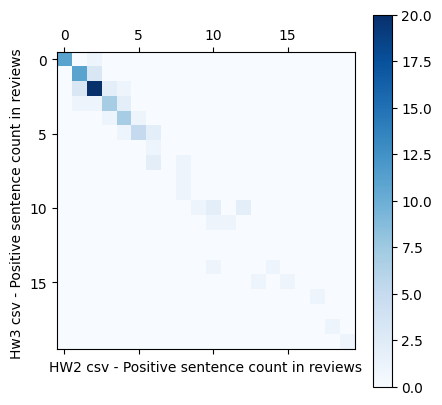

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assigning 'text_positive' column from df to y_true
y_true = df['text_positive']

# Assigning 'R_pos_count' column from merged to y_pred
y_pred = merged['R_pos_count']

# Calculating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix using matshow function from matplotlib
plt.matshow(cm, cmap=plt.cm.Blues)

# Adding colorbar to the plot
plt.colorbar()


# Adding labels to x-axis and y-axis of the plot
plt.xlabel("HW2 csv - Positive sentence count in reviews")
plt.ylabel("Hw3 csv - Positive sentence count in reviews ")


plt.show()

In [ ]:
# Looking at the confusion matrix itself
print(cm)

[[11  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3 20  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  7  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0

In [ ]:
# Obtaining a score of how much do two data sets match 
total_obs = np.sum(cm)
correct_classifications = np.diagonal(cm)
match_rate = np.sum(correct_classifications) / total_obs
print(match_rate)

0.7


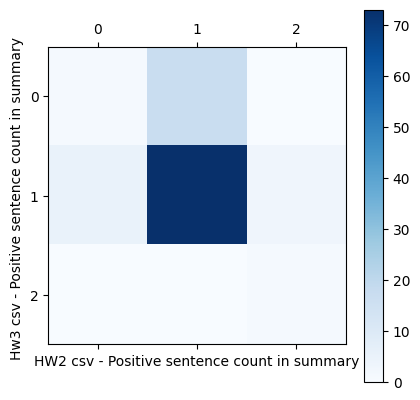

In [ ]:

y_true = df['summary_positive']
y_pred = merged['S_pos_count']

cm = confusion_matrix(y_true, y_pred)

plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("HW2 csv - Positive sentence count in summary")
plt.ylabel("Hw3 csv - Positive sentence count in summary ")
plt.show()

In [ ]:
print(cm)

[[ 1 17  0]
 [ 5 73  3]
 [ 0  0  1]]


In [ ]:
total_obs = np.sum(cm)
correct_classifications = np.diagonal(cm)
match_rate = np.sum(correct_classifications) / total_obs
print(match_rate)

0.75


# Conclusion

I used the Elmo embeddings because it takes a lot less to implement. It took around 6-7 minutes to run that code. I am not using different pre_processing techniques, because when I do use that with both embedding methods, it takes hours. I also don't use different hyperparameters for the XLNet Bilstm model, because it took me more than an hour to run that. And also, it seemed that both embeddings methods performed pretty decently, except that the Elmo was much faster and slightly better when applied to the model.

After we create a Csv and compare it with the Csv from the home work 2 using a confusion matrix, we see that the two data frames have a match rate of 0.7 and 0.75 in reviews and summaries, respectively. But going through the data myself, I have noticed that the BiLSTM using Elmo is much more accurate than the Bag_of_Words method that we used previously. It predicted negative and positive setiments much better.